In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import GridSearchCV
import eli5
from eli5.sklearn import PermutationImportance
import sklearn
import shap
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
from pdpbox import pdp
from scipy.stats import randint, uniform
from shap import TreeExplainer, GradientExplainer

In [143]:
df = pd.read_csv('/Users/matthewdmeans/Downloads/NFLPlaybyPlay2015.csv', low_memory = False)

In [144]:
def wrangle(X):
    X = X.copy()
    X.fillna(np.NaN)
    X = X.dropna(axis=0, subset=['down'])
    X = X.dropna(axis=0, subset=['PlayTimeDiff'])
    X['GoalToGo'].replace(0.0, np.NaN)
    return X

In [145]:
df = wrangle(df)

In [146]:
df = df[(df['PlayType'] == 'Run') | (df['PlayType'] == 'Pass') | (df['PlayType'] == 'Sack')]

In [147]:
features = ['Drive', 'qtr', 'down', 'TimeUnder', 'PlayTimeDiff', 'SideofField', 'yrdline100', 'ydstogo', 'GoalToGo', 'posteam', 'DefensiveTeam',
            'PlayType', 'PassLocation', 'PassLength', 'RunLocation', 'RunGap', 'DefTeamScore', 'ScoreDiff']
target = 'Yards.Gained'

In [148]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=1 - train_ratio)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

print(X_train.shape, X_val.shape, X_test.shape, y_test.shape)

(24385, 18) (4877, 18) (3252, 18) (3252,)


# Get the baseline and see how it performs on the validation set

In [149]:
baseline = y_train.mean()
baseline

5.632027885995489

In [150]:
baseline_mae_l = pd.DataFrame(y_val)
baseline_mae_l['base'] = 5.610006151322534
baseline_mae_l.drop('Yards.Gained', axis = 1, inplace = True)
print('Baseline MAE', mean_absolute_error(y_val, baseline_mae_l))

Baseline MAE 6.10365766778057


# Trying a linear regression model

In [151]:
%%time

pipe_ln = make_pipeline(
    ce.OneHotEncoder(use_cat_names= True),
    SimpleImputer(strategy = 'median'),
    LinearRegression()
)

pipe_ln.fit(X_train, y_train)

y_pred = pipe_ln.predict(X_val)

print('Validation MAE', mean_absolute_error(y_val, y_pred))

Validation MAE 5.589695752925845
CPU times: user 1.02 s, sys: 376 ms, total: 1.39 s
Wall time: 1.19 s


# Now seeing if I can tune the model to improve my MAE

In [152]:
LinearRegression().get_params().keys()

dict_keys(['copy_X', 'fit_intercept', 'n_jobs', 'normalize'])

In [153]:
transformers = make_pipeline(
    ce.OneHotEncoder(use_cat_names= True), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

In [154]:
%%time

param_grid = {'fit_intercept': [True, False],
              'normalize': [True, False],
              'copy_X': [True, False],
              'n_jobs': [None, -1]}

est = LinearRegression()
gs_cv = GridSearchCV(est, param_grid).fit(X_train_transformed, y_train)

gs_cv.best_params_

CPU times: user 27.7 s, sys: 2.43 s, total: 30.1 s
Wall time: 11.2 s


{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

In [155]:
%%time

pipe_ln = make_pipeline(
    ce.OneHotEncoder(use_cat_names= True),
    SimpleImputer(strategy = 'median'),
    LinearRegression({
        'fit_intercept': True,
        'n_jobs': None,
        'copy_X': True,
        'normalize': False
    })
)

pipe_ln.fit(X_train, y_train)

y_pred = pipe_ln.predict(X_val)

print('Validation MAE:', mean_absolute_error(y_val, y_pred))

Validation MAE: 5.589695752925845
CPU times: user 1.09 s, sys: 380 ms, total: 1.47 s
Wall time: 1.18 s


# Random Forest

In [156]:
%%time

pipe_rf = make_pipeline(
    ce.OneHotEncoder(use_cat_names= True),
    SimpleImputer(strategy = 'median'),
    RandomForestRegressor(n_estimators= 100, random_state= 42, n_jobs= -1)
)

pipe_rf.fit(X_train, y_train)

y_pred = pipe_rf.predict(X_val)
print('Validation MAE:', mean_absolute_error(y_pred, y_val))

Validation MAE: 5.622120121659489
CPU times: user 53.9 s, sys: 644 ms, total: 54.5 s
Wall time: 16.2 s


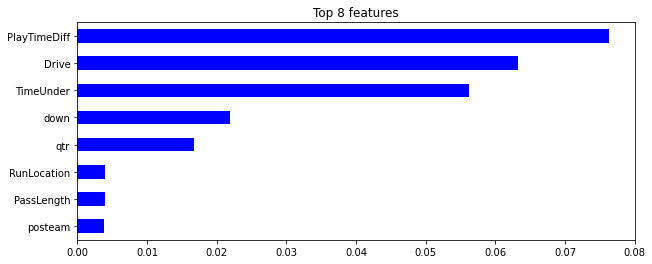

In [157]:
# Get feature importances
n1 = len(X_train.columns)
rf = pipe_rf.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_[0:n1], X_train.columns)


n = 8
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='blue');

# RidgeCV

In [158]:
%%time

pipe_r = make_pipeline(
    ce.OneHotEncoder(use_cat_names= True),
    SimpleImputer(strategy = 'median'),
    SelectKBest(f_regression, k=20),
    RidgeCV()
)

pipe_r.fit(X_train, y_train)

y_pred = pipe_r.predict(X_val)

print('Validation MAE', mean_absolute_error(y_val, y_pred))

Validation MAE 5.571701796109118
CPU times: user 987 ms, sys: 417 ms, total: 1.4 s
Wall time: 1.17 s


# Bayesian Ridge

In [159]:
%%time

pipe_br = make_pipeline(
    ce.OneHotEncoder(use_cat_names= True),
    SimpleImputer(strategy = 'median'),
    BayesianRidge()
)

pipe_br.fit(X_train, y_train)

y_pred = pipe_br.predict(X_val)

print('Validation MAE', mean_absolute_error(y_val, y_pred))

Validation MAE 5.585440988600192
CPU times: user 1.44 s, sys: 425 ms, total: 1.86 s
Wall time: 1.33 s


# Gradient Boosting

In [160]:
%%time

pipe_gb = make_pipeline(
    ce.OneHotEncoder(use_cat_names= True),
    SimpleImputer(strategy = 'median'),
    GradientBoostingRegressor()
)

pipe_gb.fit(X_train, y_train)

y_pred = pipe_gb.predict(X_val)

print('Validation MAE', mean_absolute_error(y_val, y_pred))

Validation MAE 5.504160839306192
CPU times: user 5.13 s, sys: 366 ms, total: 5.5 s
Wall time: 5.52 s


# Tuning Gradient Boosting

In [161]:
GradientBoostingRegressor().get_params().keys()

dict_keys(['alpha', 'ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'presort', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [52]:
param_distributions = { 
    'n_estimators': randint(50, 500), 
    'max_depth': [5, 10, 15, 20, None], 
    'max_features': uniform(0, 1), 
    'learning_rate': [.15, .1, .05],
    'loss': ['quantile', 'ls', 'lad', 'huber'],
    'min_samples_split': [1, 2, 3],
    'min_samples_leaf': [0, 1, 2],
}

search = RandomizedSearchCV(
    GradientBoostingRegressor(random_state=42), 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=2, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=42
)

search.fit(X_train_transformed, y_train);

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1914s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.7min finished


In [54]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)
model = search.best_estimator_

Best hyperparameters {'learning_rate': 0.05, 'loss': 'ls', 'max_depth': 20, 'max_features': 0.9737555188414592, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 495}
Cross-validation MAE 5.852993003689562


In [60]:
%%time

pipe_gbp = make_pipeline(
    ce.OneHotEncoder(use_cat_names= True),
    SimpleImputer(strategy = 'median'),
    GradientBoostingRegressor(learning_rate= .05,
                              loss = 'ls',
                              max_depth= 20,
                              max_features= 0.9737555188414592,
                              min_samples_leaf= 2,
                              min_samples_split= 2,
                              n_estimators= 495)
)

pipe_gbp.fit(X_train, y_train)

y_pred = pipe_gbp.predict(X_val)

print('Validation MAE', mean_absolute_error(y_val, y_pred))

Test MAE 5.763111501200336
CPU times: user 2min 33s, sys: 837 ms, total: 2min 34s
Wall time: 2min 35s


In [ ]:
%%time

param_grid = {'learning_rate': [.15, .1, .05],
              'max_depth': [10, 20],
              'min_samples_leaf': [12, 15],
              'max_features': [.5, .3, .1]}

est = GradientBoostingRegressor(n_estimators= 100)
gs_cv = GridSearchCV(est, param_grid).fit(X_train_transformed, y_train)

gs_cv.best_params_

In [162]:
%%time
pipe_gbp = make_pipeline(
    ce.OneHotEncoder(use_cat_names= True),
    SimpleImputer(strategy = 'median'),
    GradientBoostingRegressor(learning_rate= .05,
                              max_depth= 10,
                              max_features= .1,
                              min_samples_leaf= 12,
                              n_estimators= 100)
)

pipe_gbp.fit(X_train, y_train)

y_pred = pipe_gbp.predict(X_val)

print('Validation MAE', mean_absolute_error(y_val, y_pred))

Validation MAE 5.502081420353694
CPU times: user 2.6 s, sys: 379 ms, total: 2.98 s
Wall time: 3.01 s


### The tuned model has my best score yet, now to try it on the test set

In [167]:
pipe_gbp.fit(X_train, y_train)

y_pred = pipe_gbp.predict(X_test)

print('Test MAE', mean_absolute_error(y_test, y_pred))

Test MAE 5.524921230251139


### Compared to the baseline score

In [168]:
baseline_mae_l = pd.DataFrame(y_test)
baseline_mae_l['base'] = 5.610006151322534
baseline_mae_l.drop('Yards.Gained', axis = 1, inplace = True)
print('Baseline Test MAE:', mean_absolute_error(y_test, baseline_mae_l))

Baseline Test MAE: 6.022018846905714


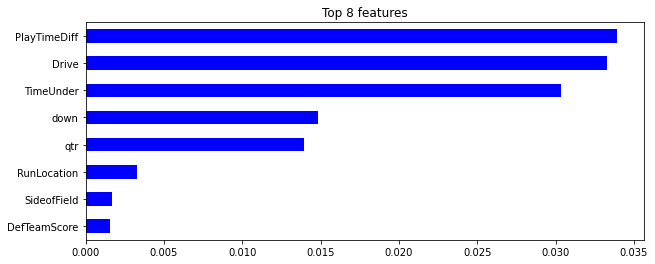

In [169]:
# Get feature importances
n1 = len(X_train.columns)
rf = pipe_gbp.named_steps['gradientboostingregressor']
importances = pd.Series(rf.feature_importances_[0:n1], X_train.columns)


n = 8
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='blue');

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <AxesSubplot:>, 'pdp_ax': <AxesSubplot:xlabel='yrdline100'>})

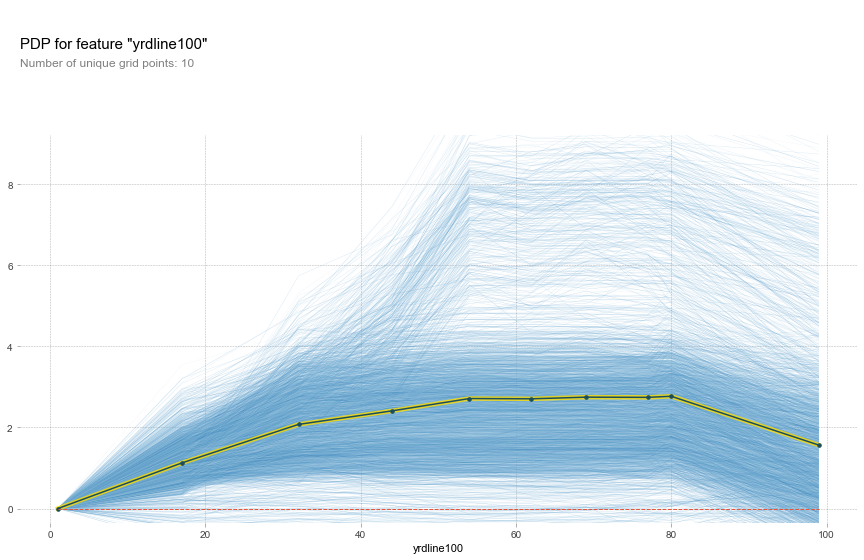

In [170]:
feature = 'yrdline100'

isolated = pdp_isolate(
    model=pipe_gbp,
    dataset=X_test,
    model_features=X_test.columns,
    feature=feature
)

pdp_plot(isolated, feature_name= feature, plot_lines= True)

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <AxesSubplot:>,
  'pdp_inter_ax': <AxesSubplot:xlabel='y', ylabel='r'>})

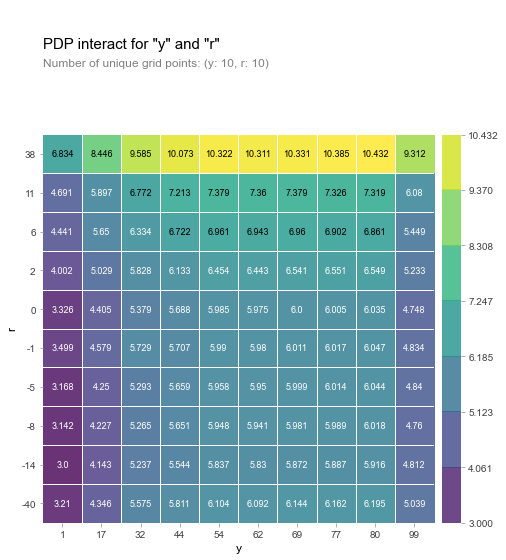

In [171]:
features = ['yrdline100', 'ScoreDiff']

interaction = pdp_interact(
    model=pipe_gbp, 
    dataset=X_test, 
    model_features=X_test.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=feature)

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <AxesSubplot:>,
  'pdp_inter_ax': <AxesSubplot:xlabel='y', ylabel='r'>})

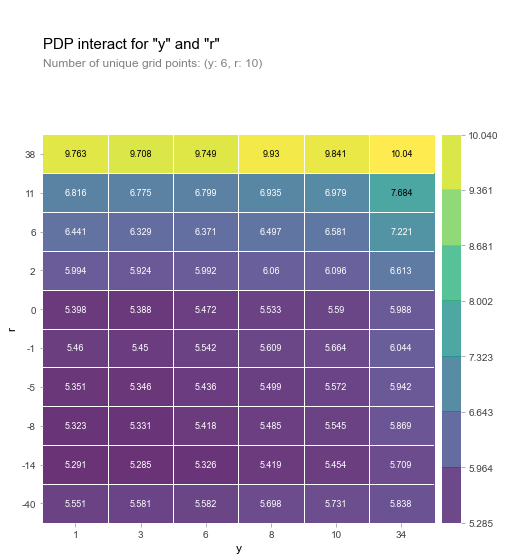

In [172]:
features = ['ydstogo', 'ScoreDiff']

interaction = pdp_interact(
    model=pipe_gbp, 
    dataset=X_test, 
    model_features=X_test.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=feature)

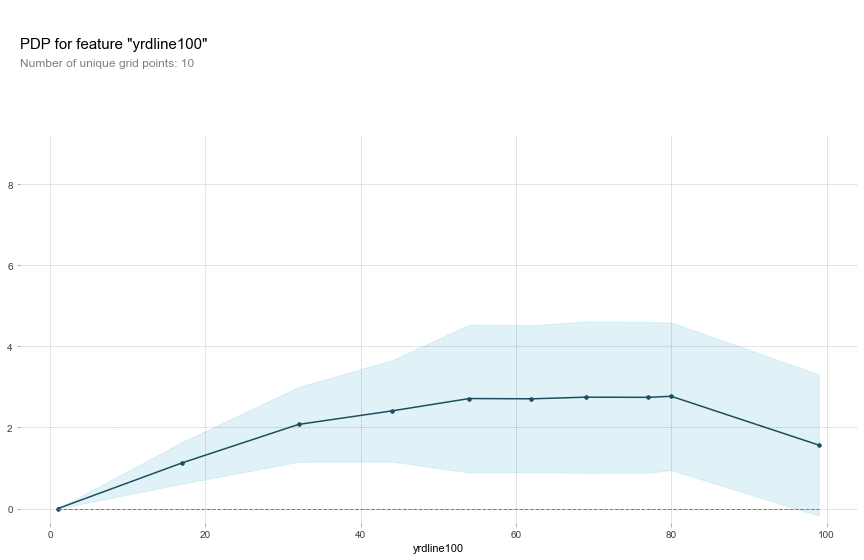

In [173]:
feature='yrdline100'
pdp_dist= pdp_isolate(
    model=pipe_gbp,
    dataset=X_test,
    model_features=X_test.columns,
    feature=feature
)
pdp.pdp_plot(pdp_dist, feature);